<center>
<img src="../../img/ods_stickers.jpg">

## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course
    
Authors: [Ilya Baryshnikov](https://www.linkedin.com/in/baryshnikov-ilya/), [Maxim Uvarov](https://www.linkedin.com/in/maxis42/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by [Inga Kaydanova](https://www.linkedin.com/in/inga-kaidanova-a92398b1/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center>Assignment #2 (demo)
## <center>Analyzing cardiovascular disease data 
    
    
**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a2-demo-analyzing-cardiovascular-data) + [solution](https://www.kaggle.com/kashnitsky/a2-demo-analyzing-cardiovascular-data-solution).**

In this assignment, you will answer questions about a dataset on cardiovascular disease. You do not need to download the data: it is already in the repository. There are some Tasks that will require you to write code. Complete them and then answer the questions in the [form](https://docs.google.com/forms/d/13cE_tSIb6hsScQvvWUJeu1MEHE5L6vnxQUbDYpXsf24).

#### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

#  Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
# Import all required modules
import pandas as pd
import numpy as np

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import plotting modules and set up 
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
!pwd

/home/dhruv/Desktop/mlcourse.ai/jupyter_english/assignments_demo


You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [3]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


It would be instructive to peek into the values of our variables.
 
Let's convert the data into *long* format and depict the value counts of the categorical features using [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

In [4]:
?pd.melt

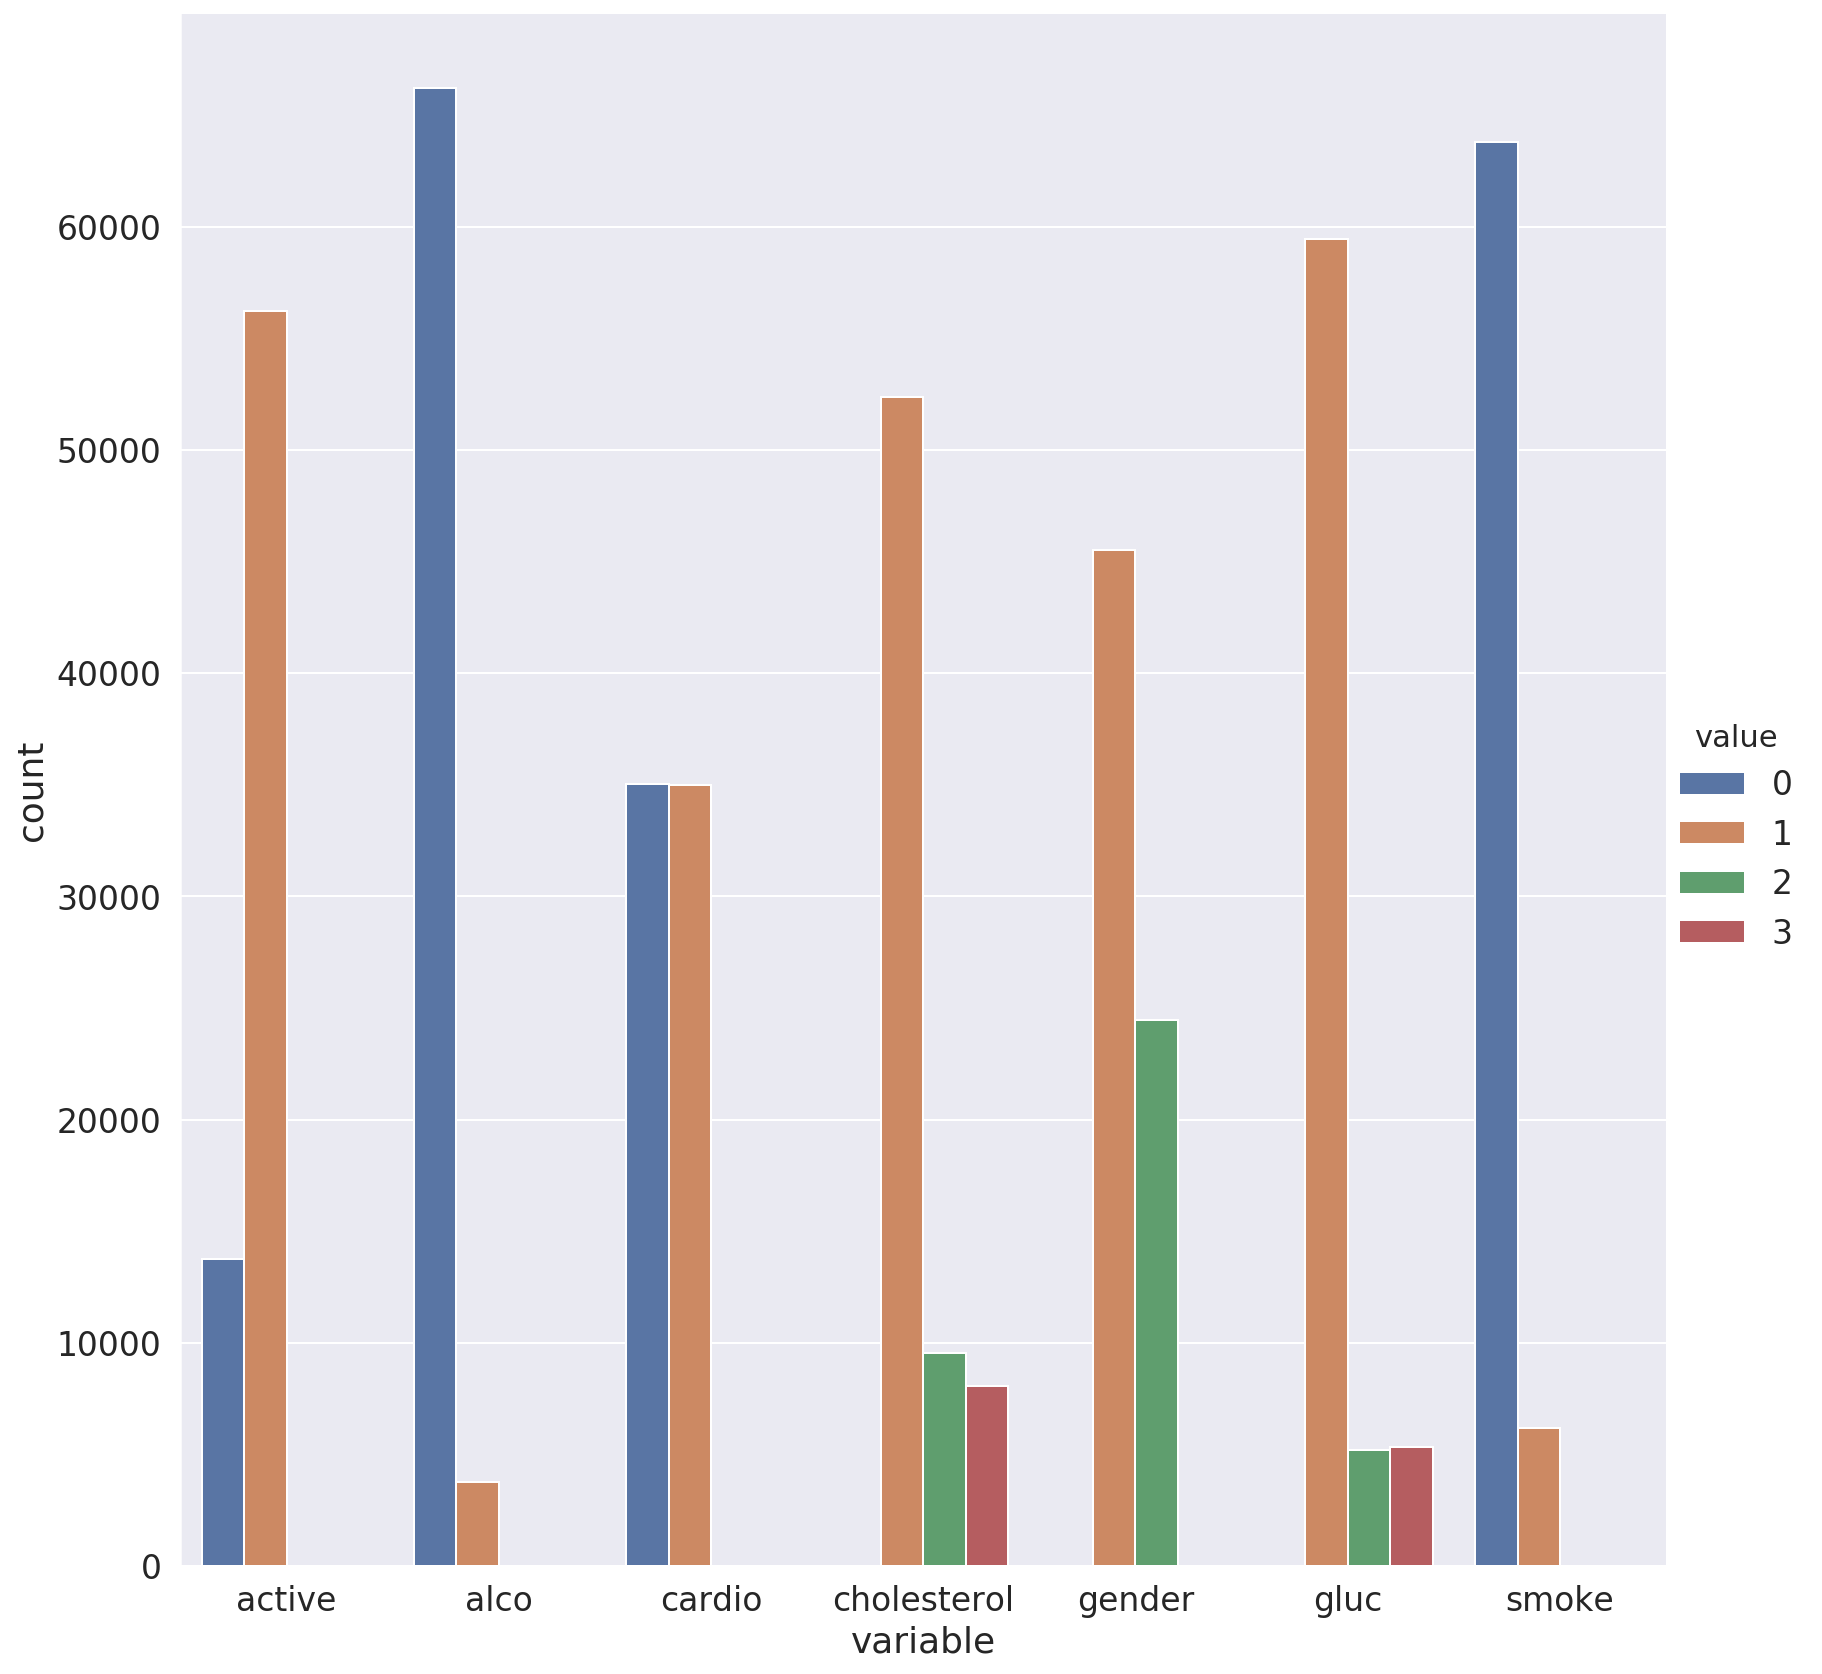

In [5]:
#Here we are converting all columns to the format Id,column name,value
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
#Thne once the melting process is  done,we groupby the column name(value) and get the value and take it's count . So for each unique category,we get the unique  value and it's count(We can do the same I guess using some sort of looping and conditional logic but this is brilliant)
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               data=df_uniques, kind='bar', size=12);

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

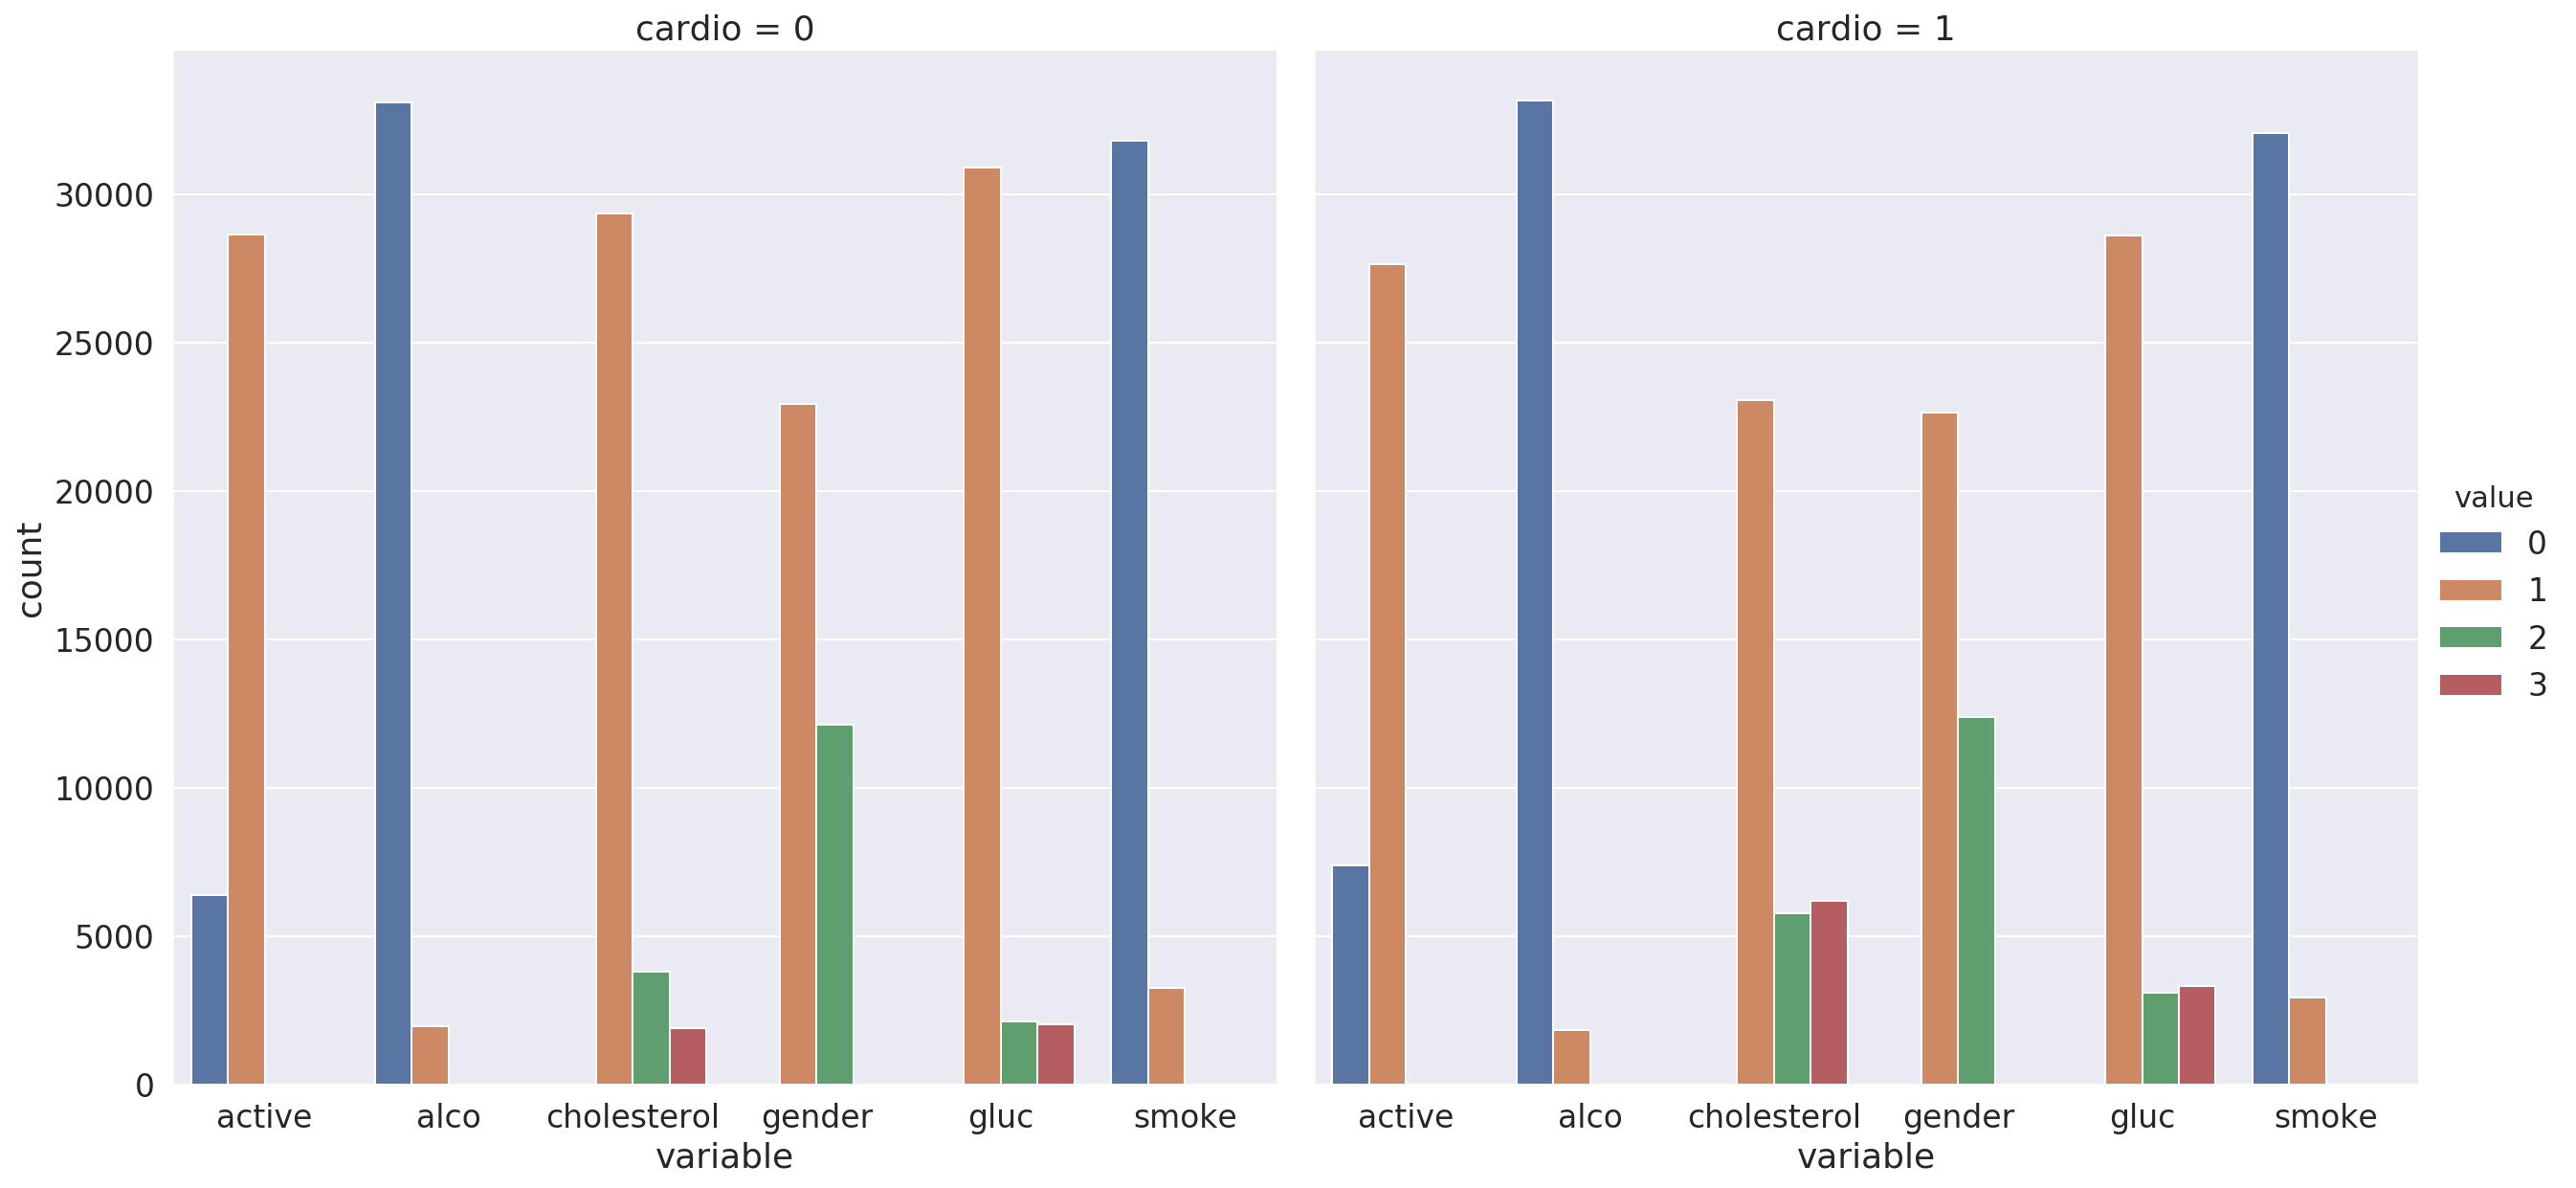

In [6]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', size=9);

#As per by my observation,the cholestrol and the gender values change based on if the person has cardio vascular disease or not.

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable. Is this a coincidence?

Now, let's calculate some statistics for the feature unique values:

In [7]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    #So if number of unique values are less than 3,then we print the dict for the same.Else we just print the column along with the nu of unique values
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding *id*);
- 7 categorical features;
- 70000 records in total.

## 1.1. Basic observations

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average. **
1. 45530 women and 24470 men
2. 45530 men and 24470 women
3. 45470 women and 24530 men
4. 45470 men and 24530 women

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 27.4 µs


Female    45530
Male      24470
Name: gender, dtype: int64

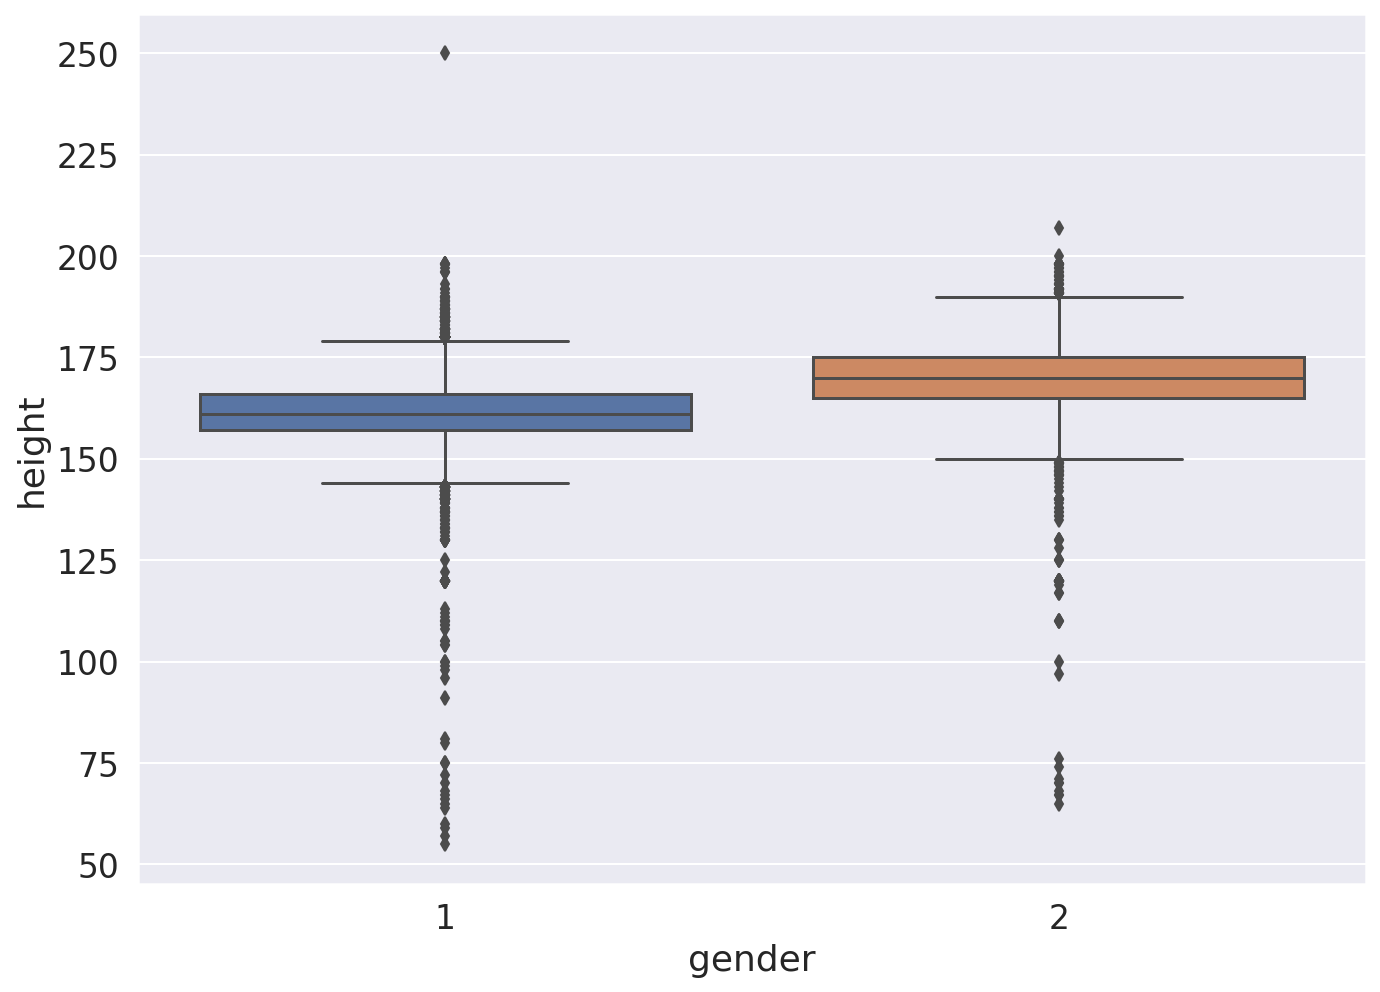

In [8]:
#Here gender is categorical and height is numeric.So this is a numeric categorical relationship so we can use boxplot.From the BoxPlot,we can infer that the gender 2 might be males since the median value for height is around 165 for gender 2 and around 155 for gender 1 (Option 1)

%time
sns.boxplot(x='gender',y='height',data=df)
df['gender']=df['gender'].map({1:"Female",2:"Male"})
df.gender.unique()
df.gender.value_counts(dropna=False)
# ?df.gender.value_counts

**Question 1.2. (1 point). Which gender more often reports consuming alcohol - men or women?**
1. women
2. men

In [9]:
#The Gender which reports the most consumption of alcohol is Men(Option 2)
df.groupby('gender')['alco'].value_counts()

gender  alco
Female  0       44369
        1        1161
Male    0       21867
        1        2603
Name: alco, dtype: int64

**Question 1.3. (1 point). What is the difference between the percentages of smokers among men and women (rounded)?**
1. 4
2. 16
3. 20
4. 24

In [10]:
#The difference between percentages for smokers among men and women is around 20%
men_smoke=df.loc[(df['gender']=='Male'),'smoke'].mean()
female_smoke=df.loc[(df['gender']=='Female'),'smoke'].mean()

print(round((men_smoke-female_smoke)*100,2))

20.1


**Question 1.4. (1 point). What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You'll need to figure out the units of feature `age` in this dataset.**

1. 5
2. 10
3. 15
4. 20

In [12]:
#According to some calucaltion,I though this could be either days,weeks,month in terms of age.By Process of Elimination and checking the calculation,I believe that the Age is given in Days since the person was born.So by that logic,the age of a person is age/365 and so Option 4 is the answer Since 2 years is around 20 months

new_age=df['age'].apply(lambda x:round(x/365))
df.insert(loc=len(df.columns),column='corrected_age',value=new_age)
# ?df.insert

df.groupby('smoke')['corrected_age'].agg(np.median)

smoke
0    54
1    52
Name: corrected_age, dtype: int64

## 1.2. Risk maps
### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is:
<img src='../../img/SCORE_CVD_eng.png' width=70%>

Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate that same ratio using our data.

Clarifications:
- Calculate ``age_years`` feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
- Cholesterol level categories differ between the figure and our dataset. The conversion for the ``cholesterol`` feature is as follows: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

In [33]:
'''Systematic COronary Risk Evaluation (SCORE): high and low cardiovascular risk charts based on gender, age, total cholesterol, systolic blood pressure and smoking status, with relative risk chart, qualifiers and instructions.'''

templ_df=df.copy()
templ_df['age_years']=templ_df.age.apply(lambda x:x//365)

people_with_age=templ_df.loc[(templ_df.age_years>=60) & (templ_df.age_years<=64)]
people_with_age

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,60
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1,61
10,15,22530,1,169,80.0,120,80,1,1,0,0,1,0,61
22,32,23046,1,158,90.0,145,85,2,2,0,0,1,1,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69973,99961,22142,2,175,72.0,130,80,1,1,0,0,1,0,60
69979,99969,22423,1,163,74.0,160,100,2,2,0,0,1,1,61
69988,99981,21978,1,160,59.0,110,70,1,1,0,0,1,0,60
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,61


In [16]:
df.cholesterol.unique()

array([1, 3, 2])

**Question 1.5. (2 points). Calculate the fraction of the people with CVD for the two segments described above. What is the ratio of these two fractions?**

1. 1
2. 2
3. 3
4. 4

## 1.3. Analyzing BMI
### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25. 

In [20]:
#Cm to Meters conversion
df['height_M']=df['height']/100

In [38]:
df['BMI']=df['weight']/np.square(df['height_M'])
df['BMI'].median()

26.374068120774975

**Question 1.6. (2 points). Choose the correct statements:**

1. Median BMI in the sample is within the range of normal BMI values.
2. The BMI for women is on average higher than for men.
3. Healthy people have, on average, a higher BMI than the people with CVD.
4. For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

In [36]:
#Average BMI for Men and Women
df.groupby('gender')['BMI'].mean().to_frame()

,BMI
gender,
Female,27.987583
Male,26.754442


In [34]:
#BMI Based on CVD or Not
df.groupby('cardio')['BMI'].mean().to_frame()

,BMI
cardio,
0,26.548175
1,28.566061


In [35]:
#Healthy Vs Non Healthy

df.groupby(['gender', 'alco', 'cardio'])['BMI'].median().to_frame()

BMI
gender alco cardio           
Female 0    0       25.654372
            1       27.885187
       1    0       27.885187
            1       30.110991
Male   0    0       25.102391
            1       26.674874
       1    0       25.351541
            1       27.530797

In [ ]:
'''For First question,the BMI is around 26.38 which is higher than the BMi normal range max value of 25(False)
For the Second Question,the BMI for Female is Higher than Males(True)
For the Third Question,the BMI for Non CVD People(Healthy) is less than that of People who have CVD(Non Healthy) False

For the Fourth Question,the BMI for Non Drinking Females is closer to the norm than for non Drinking Men
'''

## 1.4. Cleaning data

### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic 
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.

In [4]:
'''Removing records using drop where diastolic pressure is higher than systolic.
Height is Strictly less than 2.5 Percentile
Height us Strictly more than 97.5 Percentile
Weight is strictly less than 2.5 percentile
Weight is strictly more than 97.5 percentile

We are getting around 9.62 which when rounded is around 10 (Option 3)
'''

new_temp_df=df.copy(deep=True)
new_temp_df=df[(df['ap_lo']>df['ap_hi']) | 
               (df['height']<df['height'].quantile(0.025)) | 
               (df['height']>df['height'].quantile(0.975)) |
               (df['weight']<df['weight'].quantile(0.025)) |
               (df['weight']>df['weight'].quantile(0.975))]
# ?new_temp_df.height.quantile
# new_temp_df.shape[0]
print(new_temp_df.shape[0] / df.shape[0]*100)
# Filtered Records which we skipped(Basically getting those records from main Dataframe which are not there in our removed DataFrame)
filtered_rec=df.iloc[~new_temp_df.index.values]
filtered_rec

9.629999999999999


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69985,99977,18194,1,156,102.0,130,80,1,1,0,1,0,1
69984,99975,17926,2,168,80.0,120,80,1,1,0,0,1,1
69976,99964,21699,1,163,65.0,120,80,2,2,0,0,1,0
69955,99939,21726,1,164,88.0,140,90,1,1,0,0,1,0
69937,99908,14489,1,160,53.0,90,60,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,35,16608,1,170,68.0,150,90,3,1,0,0,1,1
18,28,17482,1,154,68.0,100,70,1,1,0,0,0,0
12,18,14791,2,165,60.0,120,80,1,1,0,0,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1


**Question 1.7. (2 points). What percent of the original data (rounded) did we throw away?**

1. 8
2. 9
3. 10
4. 11

# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

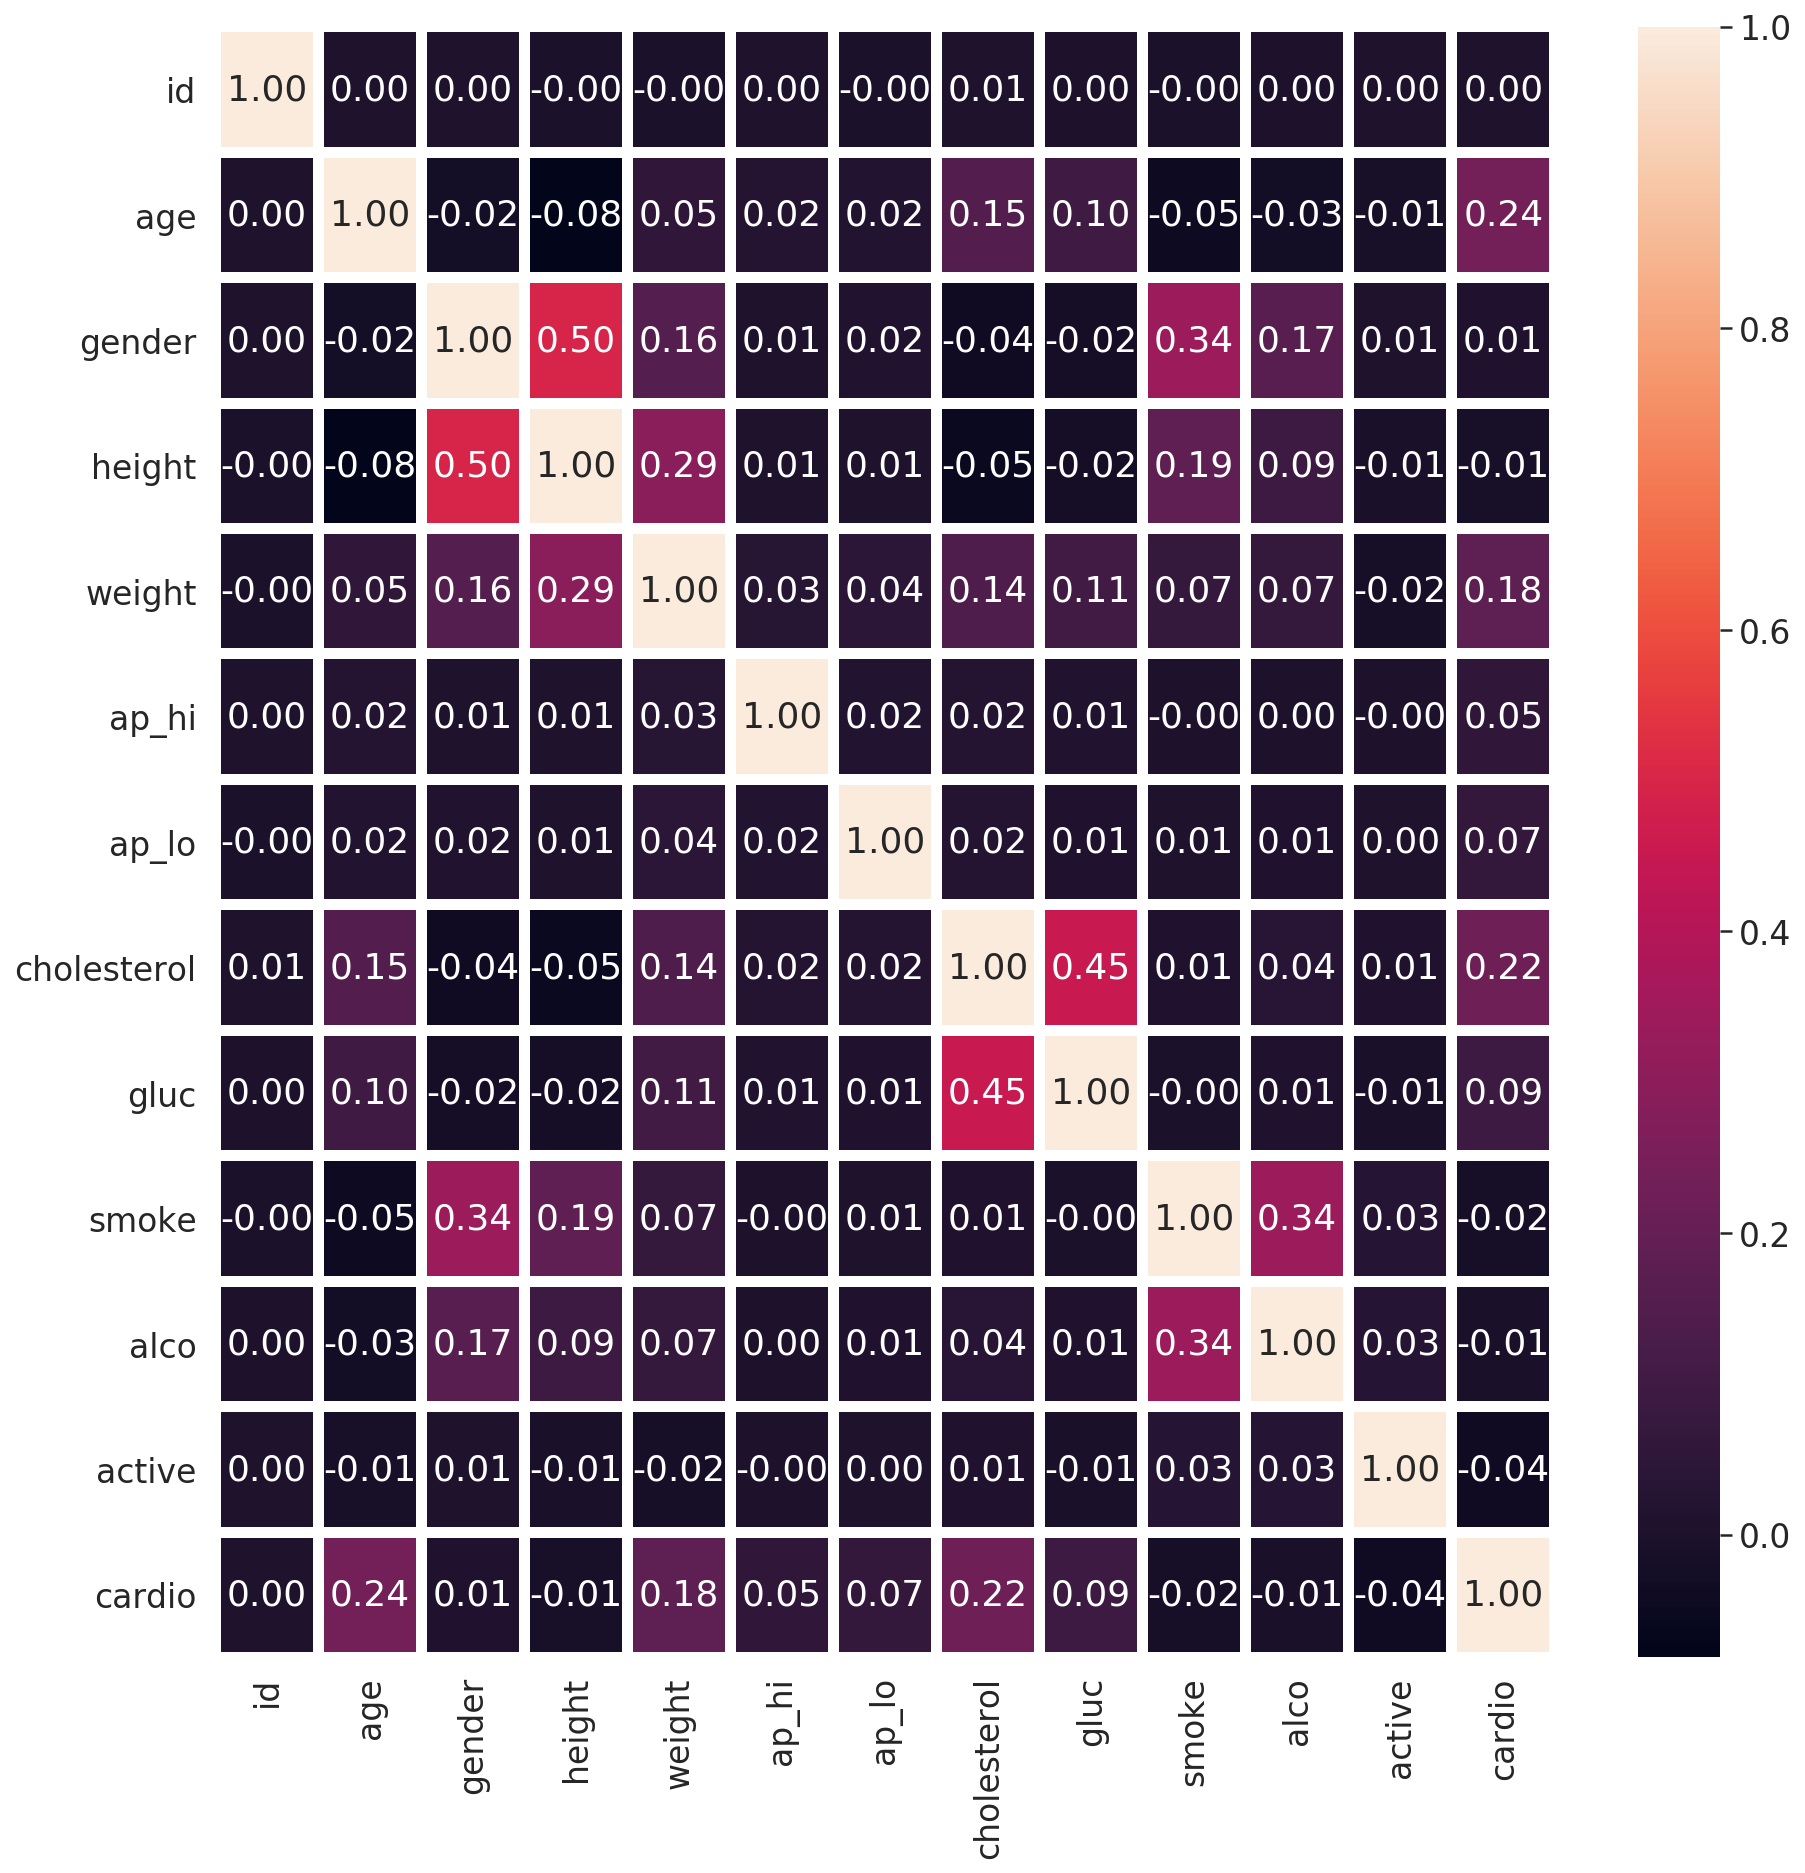

In [4]:
#(Forgot to create the coorelation matrix) Option 2 is the answer with the correlation between height and weight to be around 0.5 and the relation between height and smoke to be 0.34
new_df=df.copy(deep=True)
new_df['age']=new_df['age'].apply(lambda x:round(x/365))
new_df['height']=new_df['height']/100

new_df.drop(["id"],axis=1,inplace=True)
new_df
correlation_matrix_new_df=df.corr(method='pearson')
#This Function becomes un necessary
# correlation_matrix_new_df=correlation_matrix_new_df.apply(lambda x:round(x,2))
plt.rcParams['figure.figsize']=(15,15)
sns.heatmap(data=correlation_matrix_new_df,annot=True,fmt='.2f',linewidths=5)

** Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values *1* and *2*. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [an example](https://stackoverflow.com/a/41575149/3338479) of this for your reference.

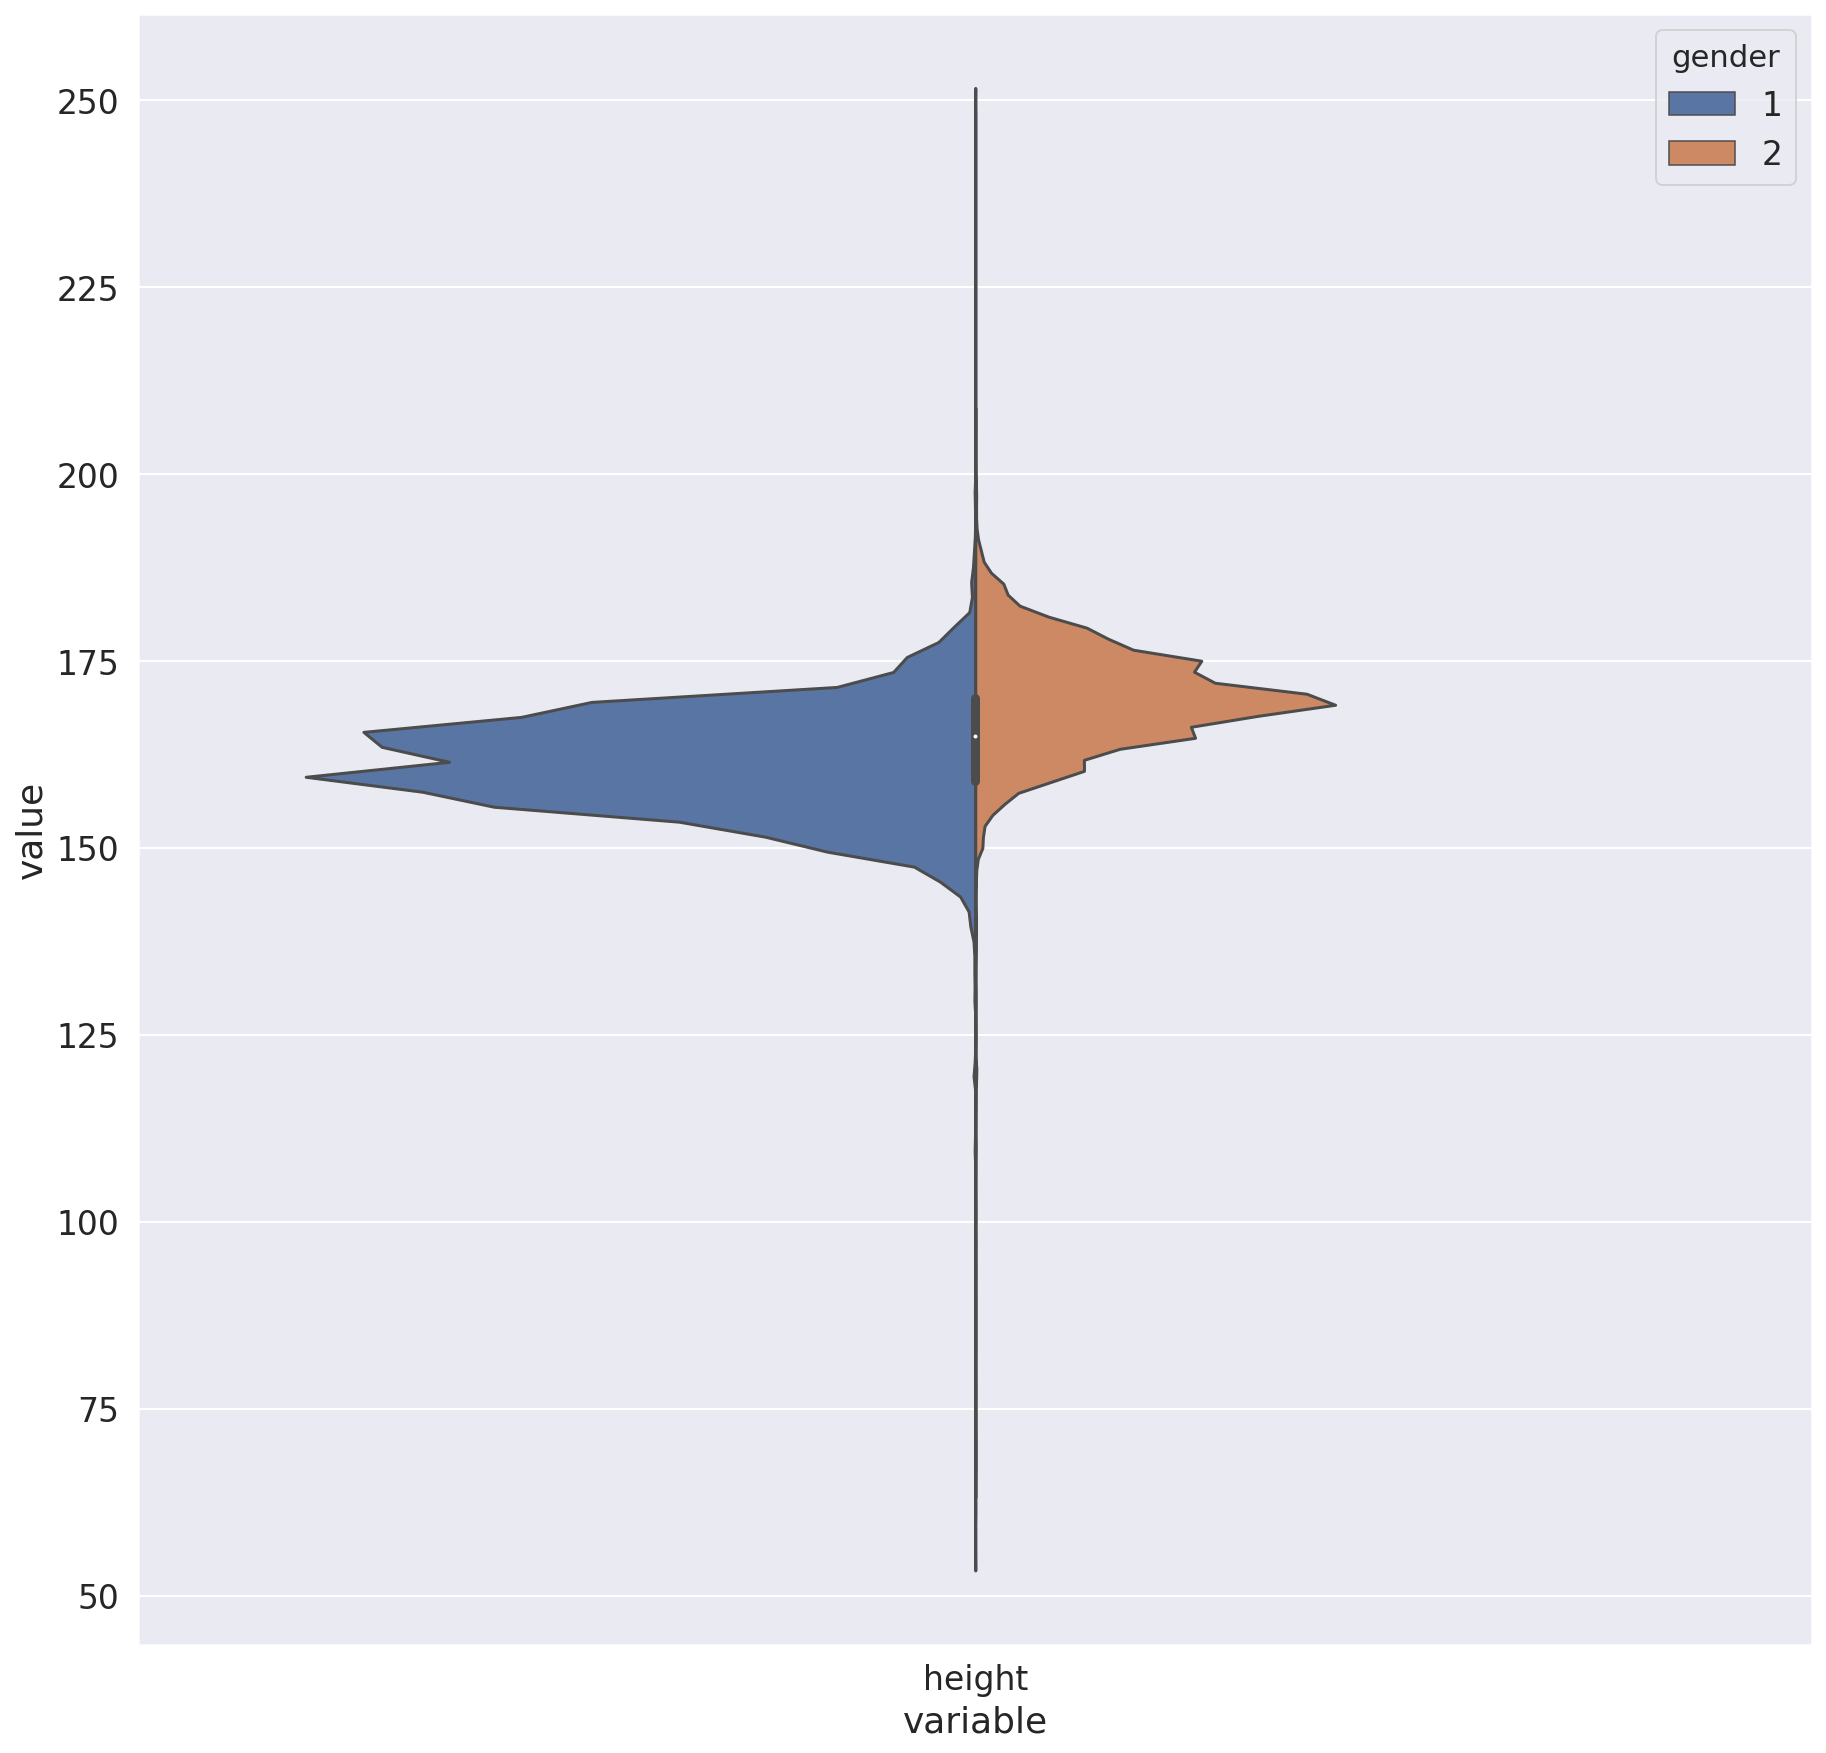

In [22]:
#Numerical Categorical Plot
test_df_1=df.copy()
test_df_2=pd.melt(frame=test_df_1,value_vars=['height'],id_vars='gender')
sns.violinplot(x='variable',y='value',hue='gender',scale='count',data=test_df_2,split=True)

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

## 2.3. Rank correlation

In most cases, *the Pearson coefficient of linear correlation* is more than enough to discover patterns in data. 
But let's go a little further and calculate a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). It will help us to identify such feature pairs in which the lower rank in the variational series of one feature always precedes the higher rank in the another one (and we have the opposite in the case of negative correlation).

### Task:

Calculate and plot a correlation matrix using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).



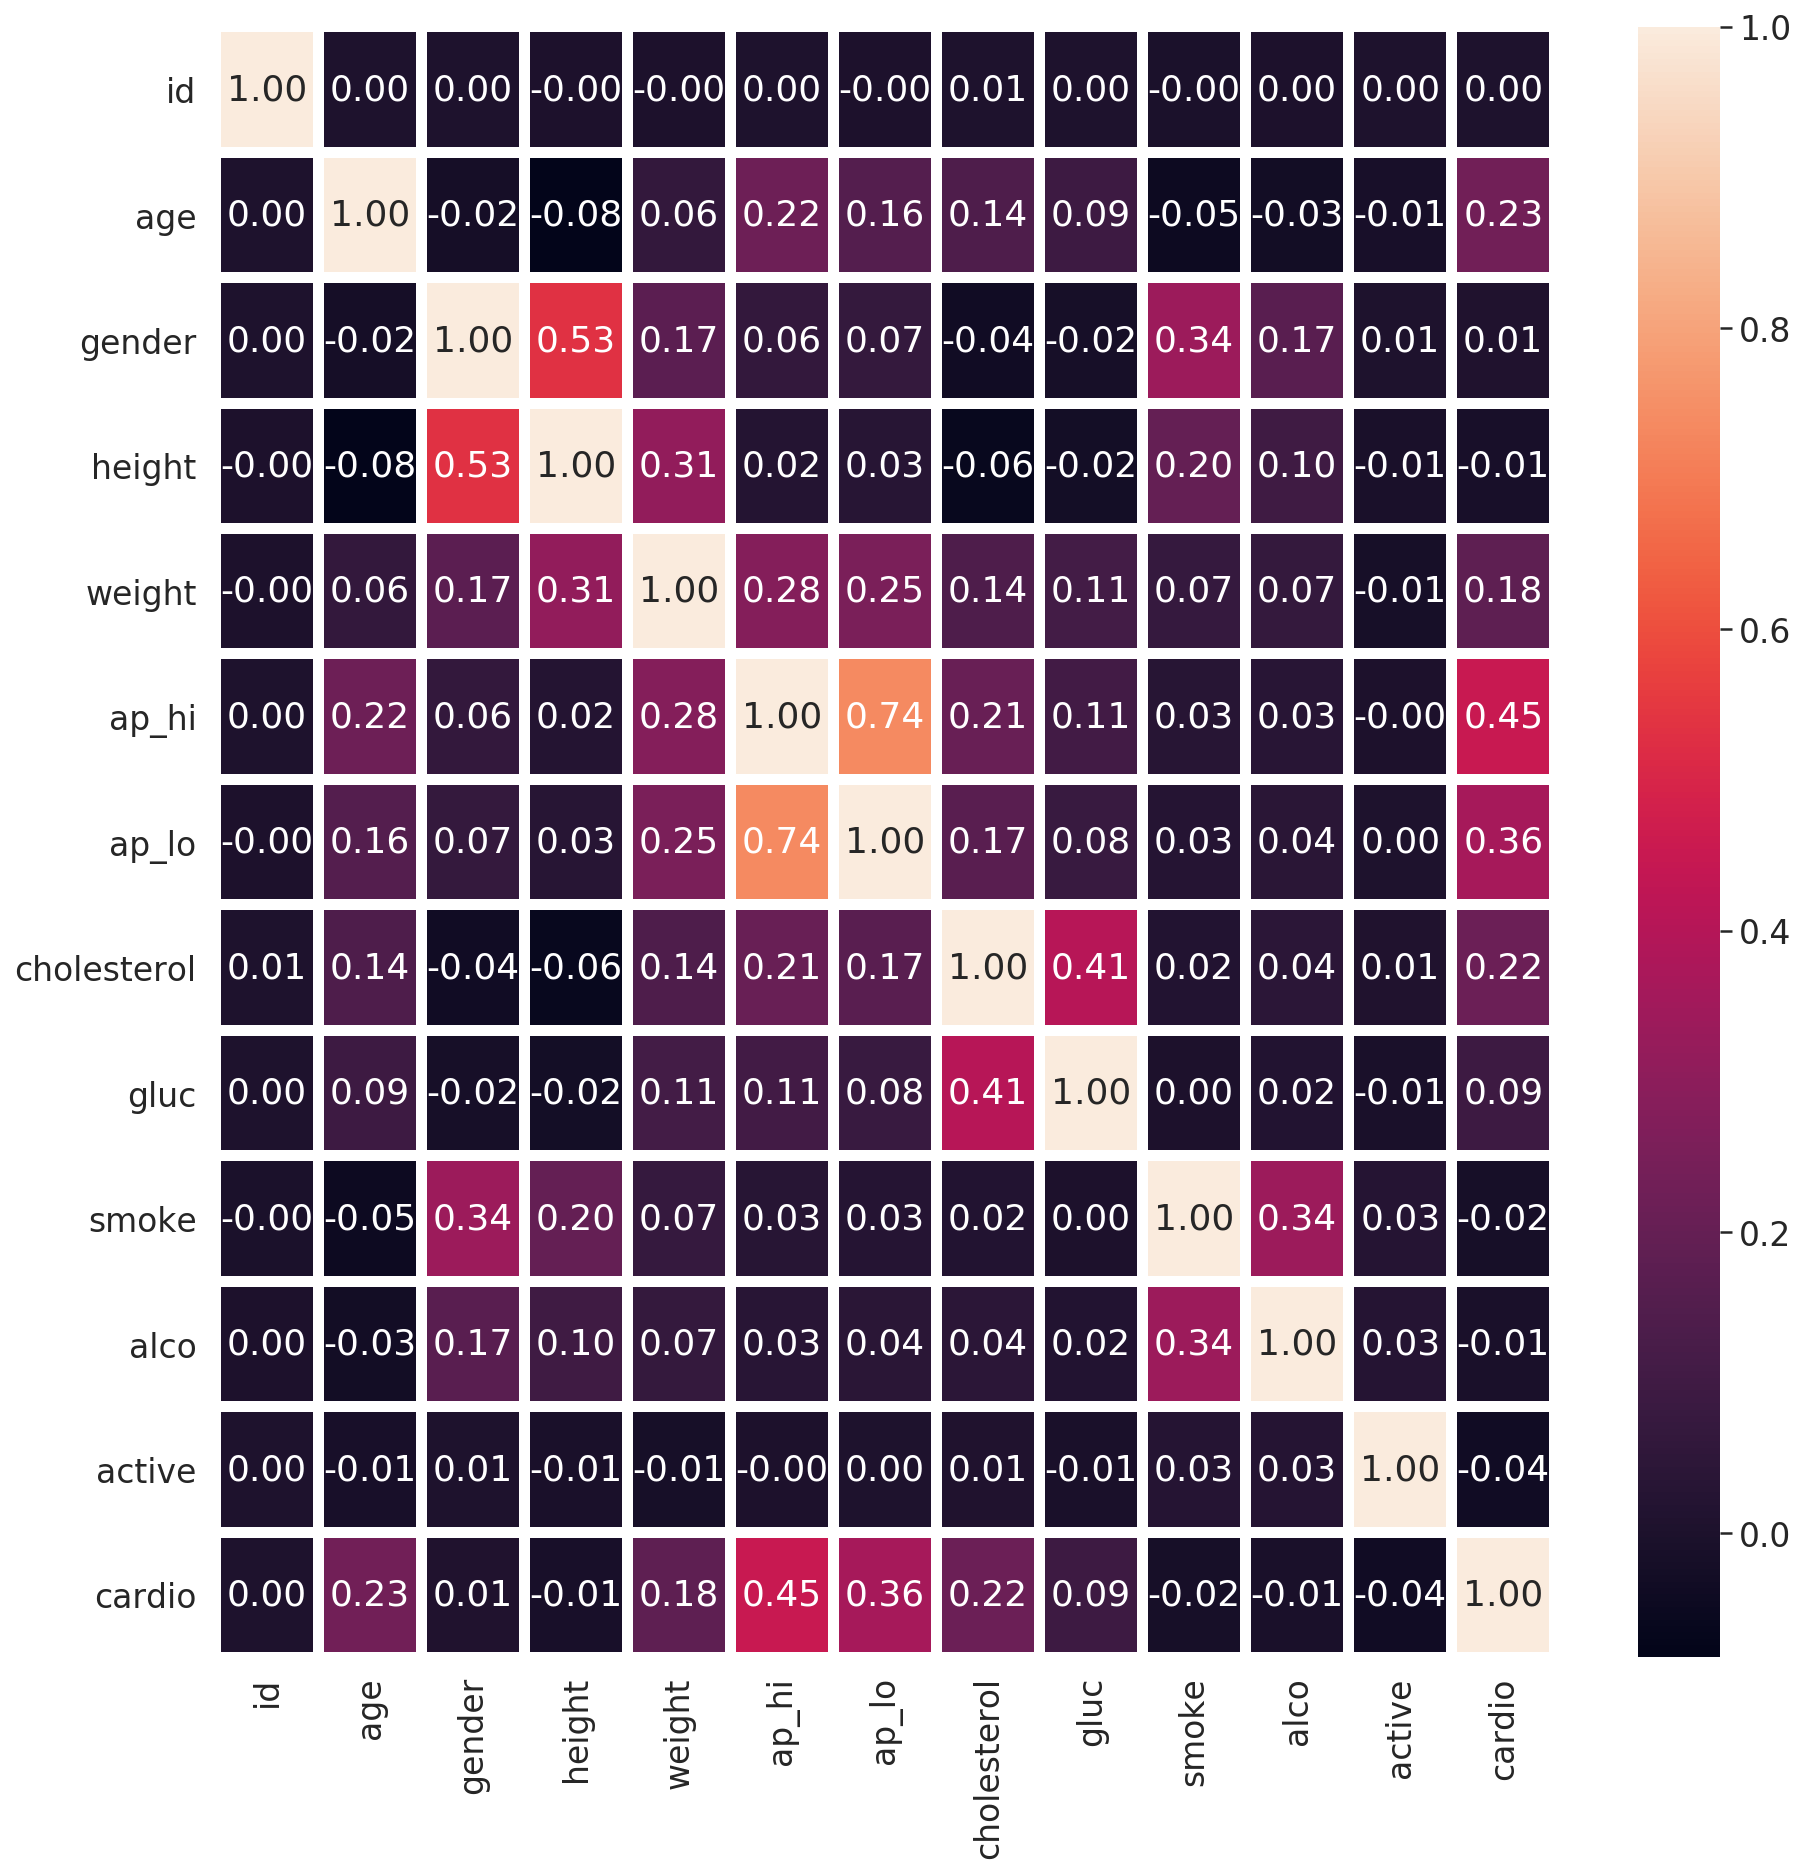

In [11]:
#For 2.2,the answer is 5(Ap_hi and Ap_lo have the strongest co relation)
#https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/expert-answers/pulse-pressure/faq-20058189
#As per the link mentioned above,the pressures are related with higher systolic and diastolic pressures a greater
#Risk of heart disease.This can be attributed to the type of data that we have collected so option no 3 is correct
test_data=df.copy()
correlation_mat=test_data.corr(method='spearman')
sns.heatmap(correlation_mat,fmt='.2f',annot=True,linewidth=5)

**Question 2.3. (1 point).** Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data.

## 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

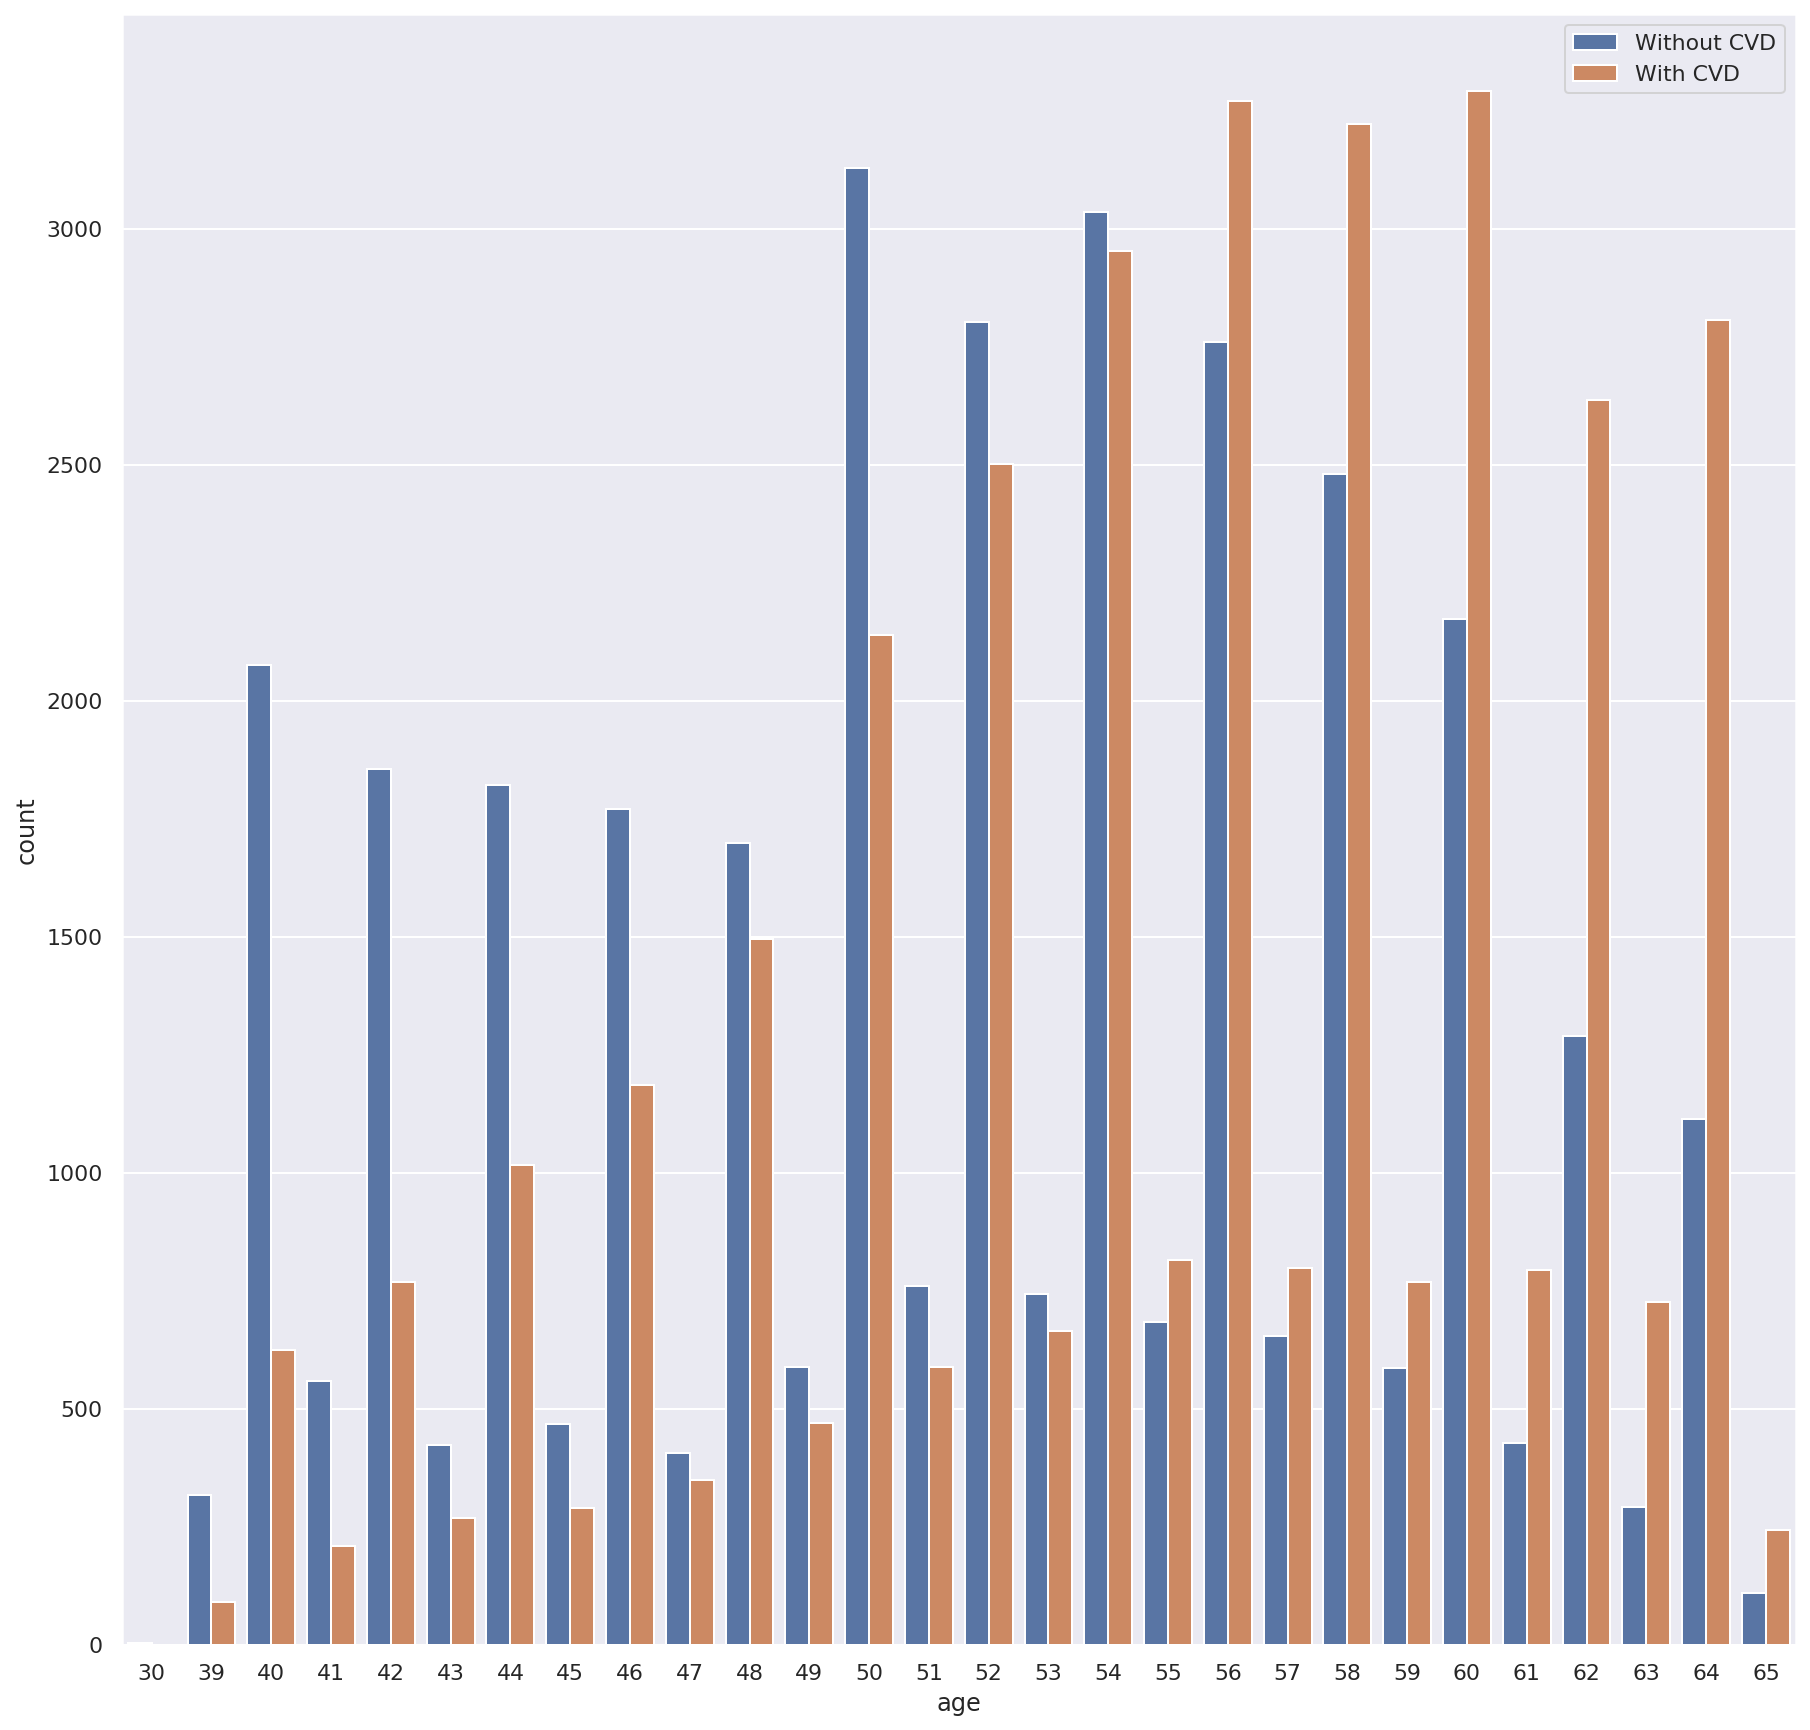

In [43]:
#Create a Countplot for Category Category grouping(Removed the Round argument to take value without floating pt) Option 2 Is the Answer (55)

temp_df=df.copy(deep=True)
temp_df.age=temp_df['age'].apply(lambda x:round(x/365))
sns.countplot(x='age',hue='cardio',data=temp_df)
plt.legend(['Without CVD','With CVD'])

**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

1. 44
2. 55
3. 64
4. 70